In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bluechip-summit-credit-worthiness-prediction/Variable_def.xlsx
/kaggle/input/bluechip-summit-credit-worthiness-prediction/Sample Submission.csv
/kaggle/input/bluechip-summit-credit-worthiness-prediction/Train.csv
/kaggle/input/bluechip-summit-credit-worthiness-prediction/Test.csv


In [2]:
df = pd.read_csv("../input/bluechip-summit-credit-worthiness-prediction/Train.csv").set_index("ID")

In [3]:
# checking the head of the dataset
df.head() 

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
ID,,,,,,,,,,,,,,
74768,LP002231,1,1,0,1,0,8328,0.000000,17,363,1,2,1,6000
79428,LP001448,1,1,0,0,0,150,3857.458782,188,370,1,1,0,6000
70497,LP002231,0,0,0,0,0,4989,314.472511,17,348,1,0,0,6000
87480,LP001385,1,1,0,0,0,150,0.000000,232,359,1,1,1,3750
33964,LP002231,1,1,1,0,0,8059,0.000000,17,372,1,0,1,3750


In [4]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'Total_Income'],
      dtype='object')

In [5]:
# checking the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5898 entries, 74768 to 84112
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            5898 non-null   object 
 1   Gender             5898 non-null   int64  
 2   Married            5898 non-null   int64  
 3   Dependents         5898 non-null   object 
 4   Education          5898 non-null   int64  
 5   Self_Employed      5898 non-null   int64  
 6   ApplicantIncome    5898 non-null   int64  
 7   CoapplicantIncome  5898 non-null   float64
 8   LoanAmount         5898 non-null   int64  
 9   Loan_Amount_Term   5898 non-null   int64  
 10  Credit_History     5898 non-null   int64  
 11  Property_Area      5898 non-null   int64  
 12  Loan_Status        5898 non-null   int64  
 13  Total_Income       5898 non-null   int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 691.2+ KB


In [6]:
df.select_dtypes(object)

,Loan_ID,Dependents
ID,,
74768,LP002231,0
79428,LP001448,0
70497,LP002231,0
87480,LP001385,0
33964,LP002231,1
...,...,...
65288,LP002560,0
86963,LP002585,0
69407,LP002175,2


In [7]:
# checking unique values
df.nunique()

Loan_ID               457
Gender                  2
Married                 2
Dependents              4
Education               2
Self_Employed           2
ApplicantIncome      3708
CoapplicantIncome    3121
LoanAmount            343
Loan_Amount_Term      259
Credit_History          2
Property_Area           3
Loan_Status             2
Total_Income           29
dtype: int64

In [8]:
df["Dependents"].unique()

array(['0', '1', '3+', '2'], dtype=object)

In [9]:
# correcting the "3+" error and also recasting to "int"
df["Dependents"] = df["Dependents"].apply(lambda x: "3" if x == "3+" else x).astype(int)
df["Dependents"].unique()

array([0, 1, 3, 2])

In [10]:
# picking the numeric parts of the values and recasting to "int"
df["Loan_ID"] = (df["Loan_ID"].str[2:]).astype(int)

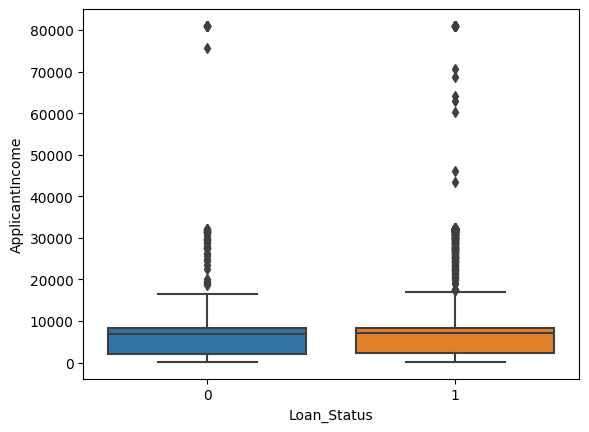

In [11]:
# studying the distribution of the ApplicantIncome feature with respect to Loan_Status
#It has outliers
sns.boxplot(x="Loan_Status",y="ApplicantIncome", data=df);

In [12]:
# Removing outliers
lower, upper = df["ApplicantIncome"].quantile([0.1, 0.9])
mask = df["ApplicantIncome"].between(lower, upper)
df_mask = df[mask]

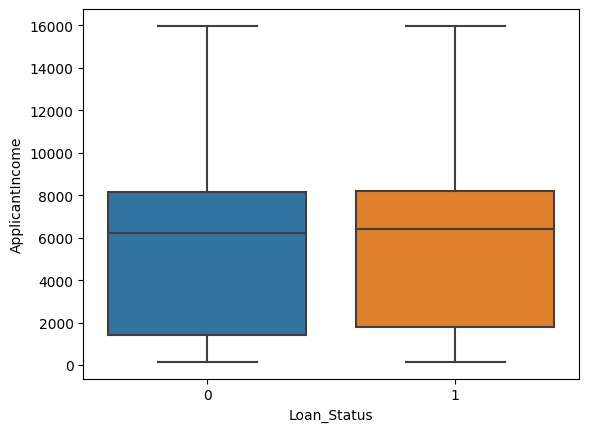

In [13]:
# outliers have been removed
sns.boxplot(x="Loan_Status",y="ApplicantIncome", data=df_mask);

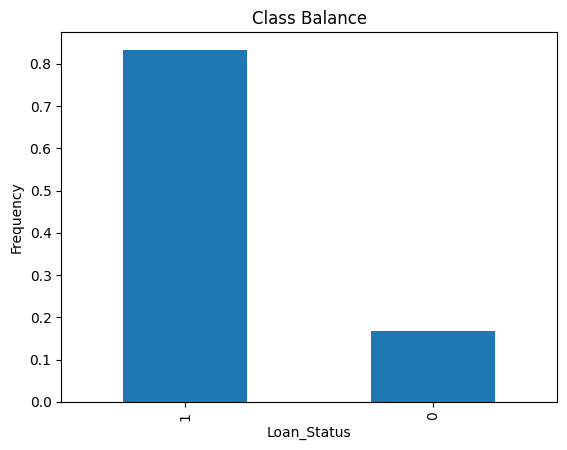

In [14]:
# checking the class balance
df["Loan_Status"].value_counts(normalize=True).plot(kind="bar")
plt.ylabel("Frequency")
plt.title("Class Balance");

In [15]:
# Separating into feature matrix and target vector
X_train = df_mask.drop(columns="Loan_Status")
y_train = df_mask["Loan_Status"]

In [16]:
# Oversampling the data because of class imbalance
oversample = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [17]:
# creating a pipeline instance
clf = make_pipeline(
    StandardScaler(), # scaling the data
    RandomForestClassifier(random_state=42) # making use of of the random forest classifier
)

In [18]:
# creating a dictionary of parameters for grid search
params = {

    "randomforestclassifier__n_estimators":range(20, 100, 15),
    "randomforestclassifier__max_depth":range(5, 50, 10),
}

In [19]:
# creating a grid search model
model = GridSearchCV(

    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
    
)

In [20]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 50, 10),
                         'randomforestclassifier__n_estimators': range(20, 100, 15)},
             verbose=1)

In [21]:
model.best_score_

0.9813436023624564

In [22]:
best_model = model.best_estimator_

In [23]:
# creating a function to prepare my test data
def wrangle(filepath):
    df = pd.read_csv(filepath).set_index("ID")
    df["Dependents"] = df["Dependents"].apply(lambda x: "3" if x == "3+" else x).astype(int)
    df["Loan_ID"] = (df["Loan_ID"].str[2:]).astype(int)

    return df

In [24]:
X_test = wrangle("../input/bluechip-summit-credit-worthiness-prediction/Test.csv")

In [25]:
X_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income
ID,,,,,,,,,,,,,
70607,2560,1,1,0,1,0,15890,871.075952,188,371,1,1,6000
58412,1379,1,1,0,0,1,6582,896.718887,17,373,0,1,6000
88755,2560,0,0,0,0,0,7869,572.900354,17,373,1,1,6000
97271,2560,1,1,0,0,0,150,0.000000,247,349,1,2,6000
70478,2231,1,1,0,0,0,8362,0.000000,17,12,1,2,3750


In [26]:
X_test.index

Index([70607, 58412, 88755, 97271, 70478, 19108, 29374, 28476, 63397, 97950,
       ...
       21827, 20774, 46675, 19432, 72089, 15578, 87689, 42584, 44709, 75533],
      dtype='int64', name='ID', length=2528)

In [27]:
predictions = best_model.predict(X_test)

In [28]:
output = pd.DataFrame({"ID":X_test.index, "Loan_Status":predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
